In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import PIL
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
import joblib

In [2]:
def CalcularAtributos(printDebug, path, trat, cell, window, features, cellcode, df_atributos):
       
    img = [cv2.imread(path+cell+file, cv2.IMREAD_UNCHANGED) for file in os.listdir(path+cell) if file.endswith(".tif")]
    # remove first 10 images
    del img[:10]

    # convert img from list to np.array
    img = np.array(img)

    # mean of each pixel
    img_mean = np.mean(img, axis=0)
        
    max_mean = img_mean.max()
    
    # Normalizar la intensidad promedio a su máximo
    shape = img_mean_norm2.shape

    # Distancia desde el pixel central al borde de la ventana 
    MidWindow = window//2
    
    # Creación de un array con todas las texturas
    testraster = np.full(shape=(len(features),img_mean.shape[0],img_mean.shape[1]),
                 fill_value=0,dtype='float64')
    
    # Recorrer toda la imagen sin los bordes
    for i in range(MidWindow, testraster[0].shape[0]-MidWindow):
        for j in range(MidWindow, testraster[0].shape[1]-MidWindow):

            #Calculate GLCM on a window
            glcm_window = img_mean[i-MidWindow: i+MidWindow+1, j-MidWindow : j+MidWindow+1]
            glcm_window = glcm_window.astype('uint8')    
            glcm = skimage.feature.graycomatrix(glcm_window, [1], [0],  symmetric = True, normed = True )

            #Calculate textures and replace center pixel
            for k in range(len(features)):
                texture_prop = skimage.feature.graycoprops(glcm, features[k])
                average_texture = np.average(texture_prop, axis=1, weights=None, returned=False)
                testraster[k,i,j] = average_texture
    
    if(printDebug):
        plt.figure()
        fig, ((ax0, ax1),(ax2, ax3),(ax4, ax5)) = plt.subplots(3, 2)
        fig.suptitle('Texturas'+cell)

        ax0.imshow(testraster[0],cmap = 'gray')
        ax0.set_title(features[0])
        ax1.imshow(testraster[1],cmap = 'gray')
        ax1.set_title(features[1])
        ax2.imshow(testraster[2],cmap = 'gray')
        ax2.set_title(features[2])
        ax3.imshow(testraster[3],cmap = 'gray')
        ax3.set_title(features[3])
        ax4.imshow(testraster[4],cmap = 'gray')
        ax4.set_title(features[4])
        ax5.imshow(testraster[5],cmap = 'gray')
        ax5.set_title(features[5])

        fig.set_size_inches(30, 20)
        for ax in fig.get_axes():
            ax.label_outer()

        plt.savefig('Celulas_RF/FigsTextures/'+trat+cellcode+'_'+str(shape)+'_Textures.tif', format='tif', dpi=96, bbox_inches='tight', pad_inches=0)
    
    df_atributos['Celula_ID'] = cell
    for textura in range(len(features)):
        df_atributos[features[textura]] = testraster[textura].flatten()
        
    df_atributos.to_csv('Celulas_RF/df_atributos/'+trat+cellcode+'_atributos.csv') 
    return df_atributos
    

In [3]:
def Cuentitas(path, trat, cell, cellcode):
       
    img = [cv2.imread(path+cell+file, cv2.IMREAD_UNCHANGED) for file in os.listdir(path+cell) if file.endswith(".tif")]
    # remove first 10 images
    del img[:10]

    # convert img from list to np.array
    img = np.array(img)

    # mean of each pixel
    img_mean = np.mean(img, axis=0)
        
    # variance of each pixel
    img_var = np.var(img, axis=0)
    max_mean = img_mean.max()
    # calculate brightness 
    img_B = img_var/img_mean
    max_B = img_B.max()
    
    # Normalizar la intensidad promedio a su máximo
    img_mean_norm2 = img_mean/max_mean
    shape = img_mean_norm2.shape
    
    plt.figure(figsize=(340/96, 340/96), dpi=96)
    plt.imshow(img_mean_norm2)
    plt.axis('off')
    plt.savefig('Celulas_RF/FigsMeanIntesityNorm/'+trat+cellcode+'_'+str(shape)+'_MeanIntensityNorm.tif', format='tif', dpi=96, bbox_inches='tight', pad_inches=0)

    # Normalizar el brillo a su máximo
    img_B_norm2 = img_B/max_B
    
    # scatter plot B vs mean
    plt.figure()
    plt.scatter(img_mean_norm2, img_B_norm2, s=0.004, c='black')
    plt.title('B vs Intensity')
    plt.xlabel('Instensity')
    plt.ylabel('Brightness')
    
    df = pd.DataFrame()
    df['Mean'] = img_mean_norm2.flatten()
    df['Brightness'] = img_B_norm2.flatten()
 
    return img_mean_norm2, img_B_norm2, df

In [4]:
def region(target, n, trat, cellcode, min_B, max_B, min_mean, max_mean, img_mean_norm2, img_B_norm2):
       
    # filter roi
    mask_min_int = img_mean_norm2 > min_mean
    mask_max_int = img_mean_norm2 < max_mean

    mask_min_B = img_B_norm2 > min_B 
    mask_max_B = img_B_norm2 <  max_B

    roi = mask_min_int * mask_max_int * mask_min_B * mask_max_B
    roi = roi * n
    #roi = roi.astype('uint8')
    shape = img_mean_norm2.shape
    
    plt.figure(figsize=(340/96, 340/96), dpi=96)
    plt.imshow(roi)
    plt.axis('off')
    plt.savefig('Celulas_RF/Masks/'+trat+cellcode+'_'+target[n]+'_'+str(shape)+'.tif', format='tif', dpi=96, bbox_inches='tight', pad_inches=0)
    
    # show roi in mean image
    img_mean_norm2_reshape = np.reshape(img_mean_norm2*255, (256, 256, 1)).astype('uint8')
    # creamos nuevos canales para poder visualizar el roi
    img_mean_norm2_reshape = np.repeat(img_mean_norm2_reshape, 3, axis=2)
    # incrementamos la intensidad para que sea vea mejor
    img_mean_norm2_reshape = img_mean_norm2_reshape*10
    
    roi_reshape = np.reshape(roi, (256, 256, 1)).astype('uint8')
    roi_reshape = np.repeat(roi_reshape, 3, axis=2)
    mask_roi = roi_reshape > 0
    roi_rojo = roi_reshape*[255,0,150]
    
    img_mean_norm2_reshape[mask_roi] = roi_rojo[mask_roi]
  
    fig = plt.figure()
    plt.imshow(img_mean_norm2_reshape) 
    plt.title('ROI')

    return roi


## Análisis manual
- Leemos todas las imagenes de la celula, una por una. 
- Calculamos la intensidad y el brillo.
- Delimitamos las regiones viendo el gráfico de Brillo vs Intensidad
- Generamos un dataset por cada celula con los atributos Mean, Brightness and target

In [8]:
# número de celula
cellNumber = 15


In [6]:
dfByCell = {}
target = { 1 : 'CITOPLASMA', 2 : 'NUCLEO', 3 : 'ARRAY', 0 : 'BACKGROUND'}

In [137]:
os.listdir(path)

['GRtetra 05.oif.files',
 'GRtetra 03.oif.files',
 'GRtetra 14.oif.files',
 'GRtetra 11.oif.files',
 'GRtetra 13.oif.files',
 'GRtetra 17.oif.files',
 'GRtetra 04.oif.files',
 'GRtetra 06.oif.files',
 'GRtetra 01.oif.files',
 'GRtetra 10.oif.files',
 'GRtetra 07.oif.files',
 'GRtetra 08.oif.files',
 'GRtetra 16.oif.files',
 'GRtetra 15.oif.files',
 'GRtetra 02.oif.files',
 'GRtetra 09.oif.files',
 'GRtetra 12.oif.files']

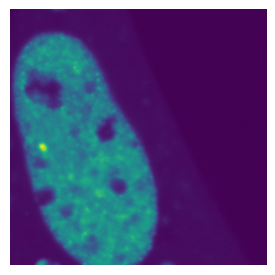

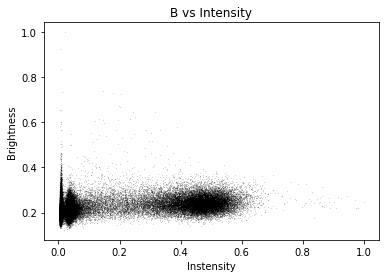

In [9]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GFPGRtetra/'
trat = 'GR_'
cell = os.listdir(path)[cellNumber]+'/'
cellcode = cell[0:8]
img_mean_norm2, img_B_norm2, df = Cuentitas(path, trat, cell, cellcode)

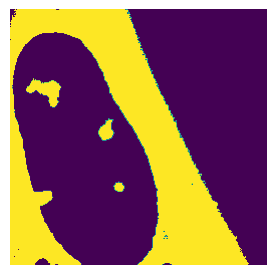

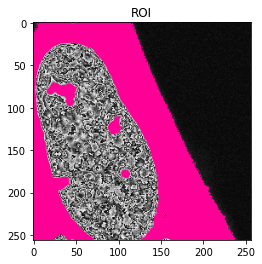

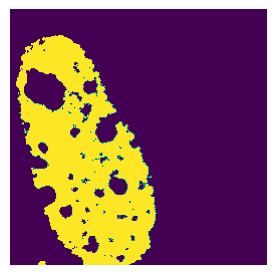

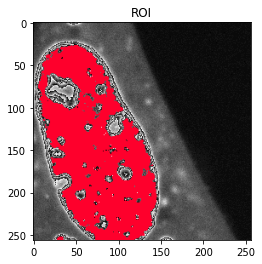

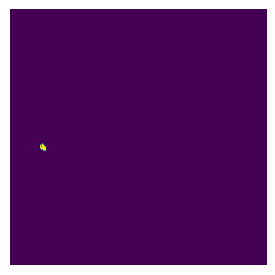

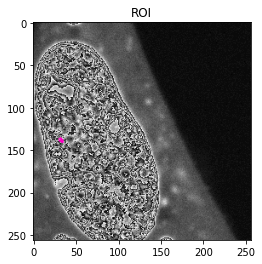

In [131]:
min_B = 0.1
max_B = 0.5
roi_citoplasma  = region(target, 1, trat, cellcode, min_B, max_B, 0.02, 0.15, img_mean_norm2,img_B_norm2)
roi_nucleo = region(target, 2, trat, cellcode, min_B, max_B, 0.35, 0.6, img_mean_norm2,img_B_norm2)
roi_array = region(target, 3, trat, cellcode, min_B, max_B, 0.8, 1, img_mean_norm2,img_B_norm2)


In [132]:
labels = roi_nucleo + roi_citoplasma 
labels = labels.flatten()
df['target'] = labels
df['target'] = df['target'].apply(lambda x : target[x])
df.to_csv('Celulas_RF/df_masks/'+trat+cellcode+'_'+str(cellNumber+1)+'_'+'_masks.csv')   

In [185]:
dfByCell[cellNumber] = df

In [184]:
len(dfByCell)

14

In [186]:
pathCsv = '/home/bruno/Downloads/pattern-recognition-in-cells/Celulas_RF/df_atributos/'
dirs = os.listdir(pathCsv)
key = 0
for file in dirs:
    if('GR_CORT' in file):
        dfByCell[key]=pd.read_csv(pathCsv+file)
        key+=1

In [156]:
range(len(dirs))

range(0, 30)

#### Cosas a agregar
- Hacer las mascaras para algun experimento que tenga array presente, para agregar al training.
- Mezclar celulas de diferentes experimentos para que el training no tenga sesgo.

# Acá termina la parte manual

## Feature engineering
Generamos _texturas_ para cada pixel. De esta manera vamos a poder alimentar al modelo con una mayor cantidad de atributos por muestra

In [162]:
window = 7
features = ['contrast', 'dissimilarity','homogeneity','ASM','energy','correlation']
directory = '/media/usuario/Datos/eve/ifibyne/3_Lab/Experimentos/dinamica LXR-RXR/NB2/microscopio/'
dfFinals = {}

In [165]:
range(len(os.listdir(path)))

range(0, 17)

KeyError: 16

<Figure size 432x288 with 0 Axes>

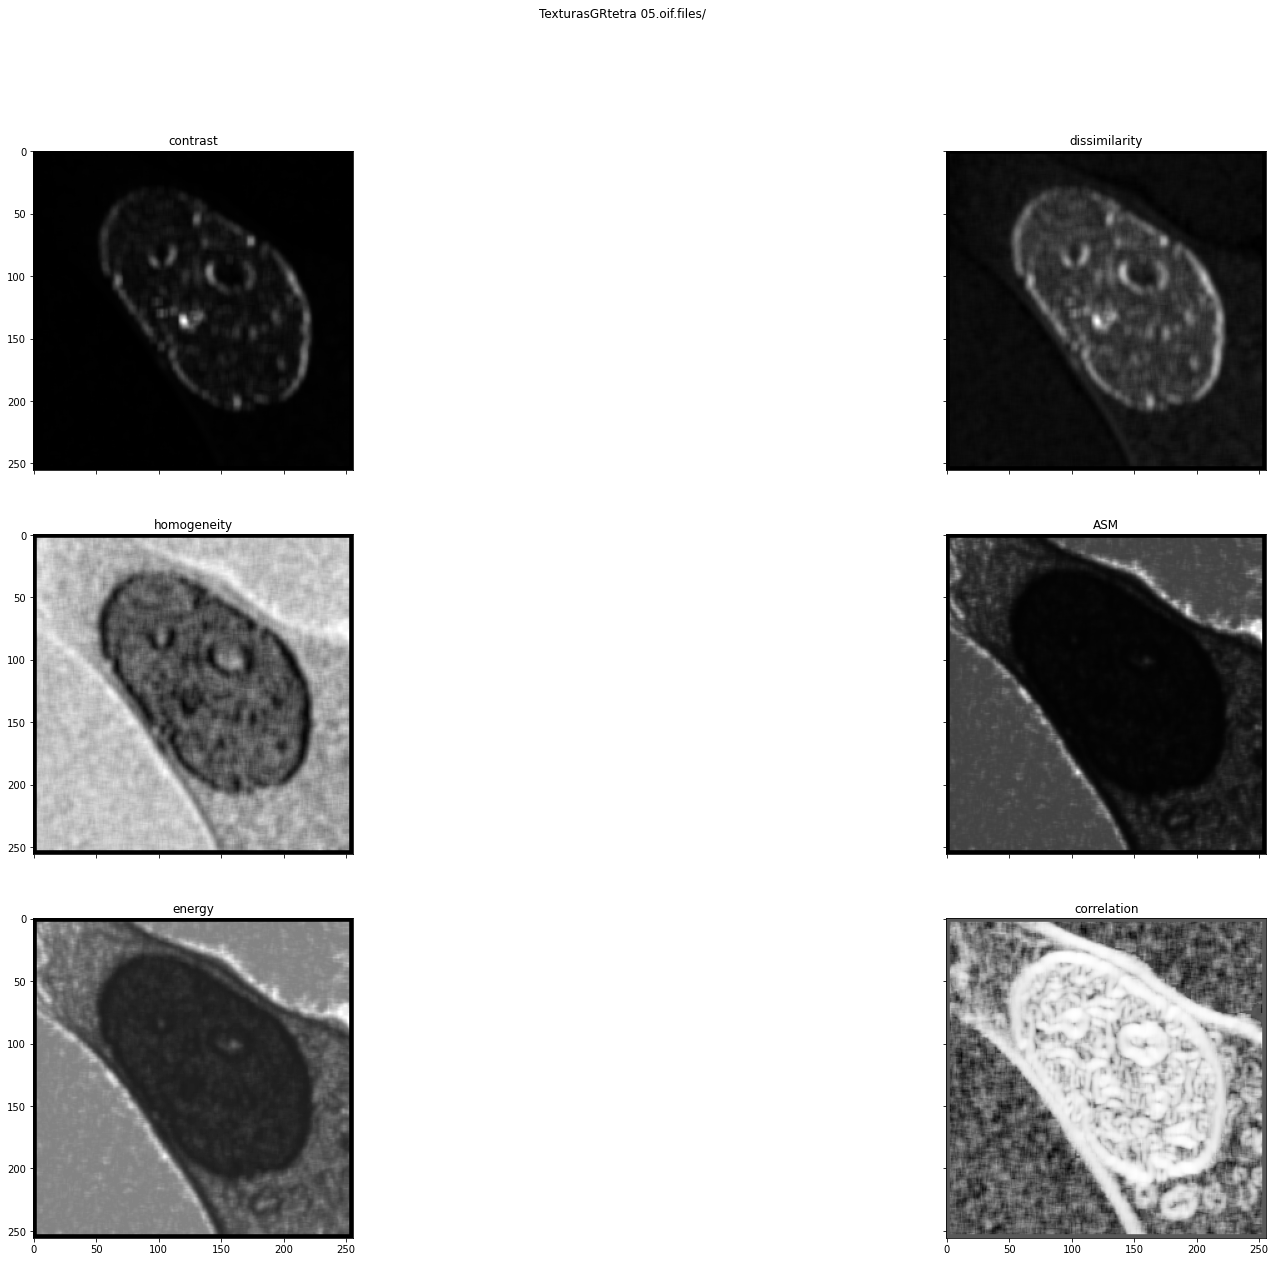

<Figure size 432x288 with 0 Axes>

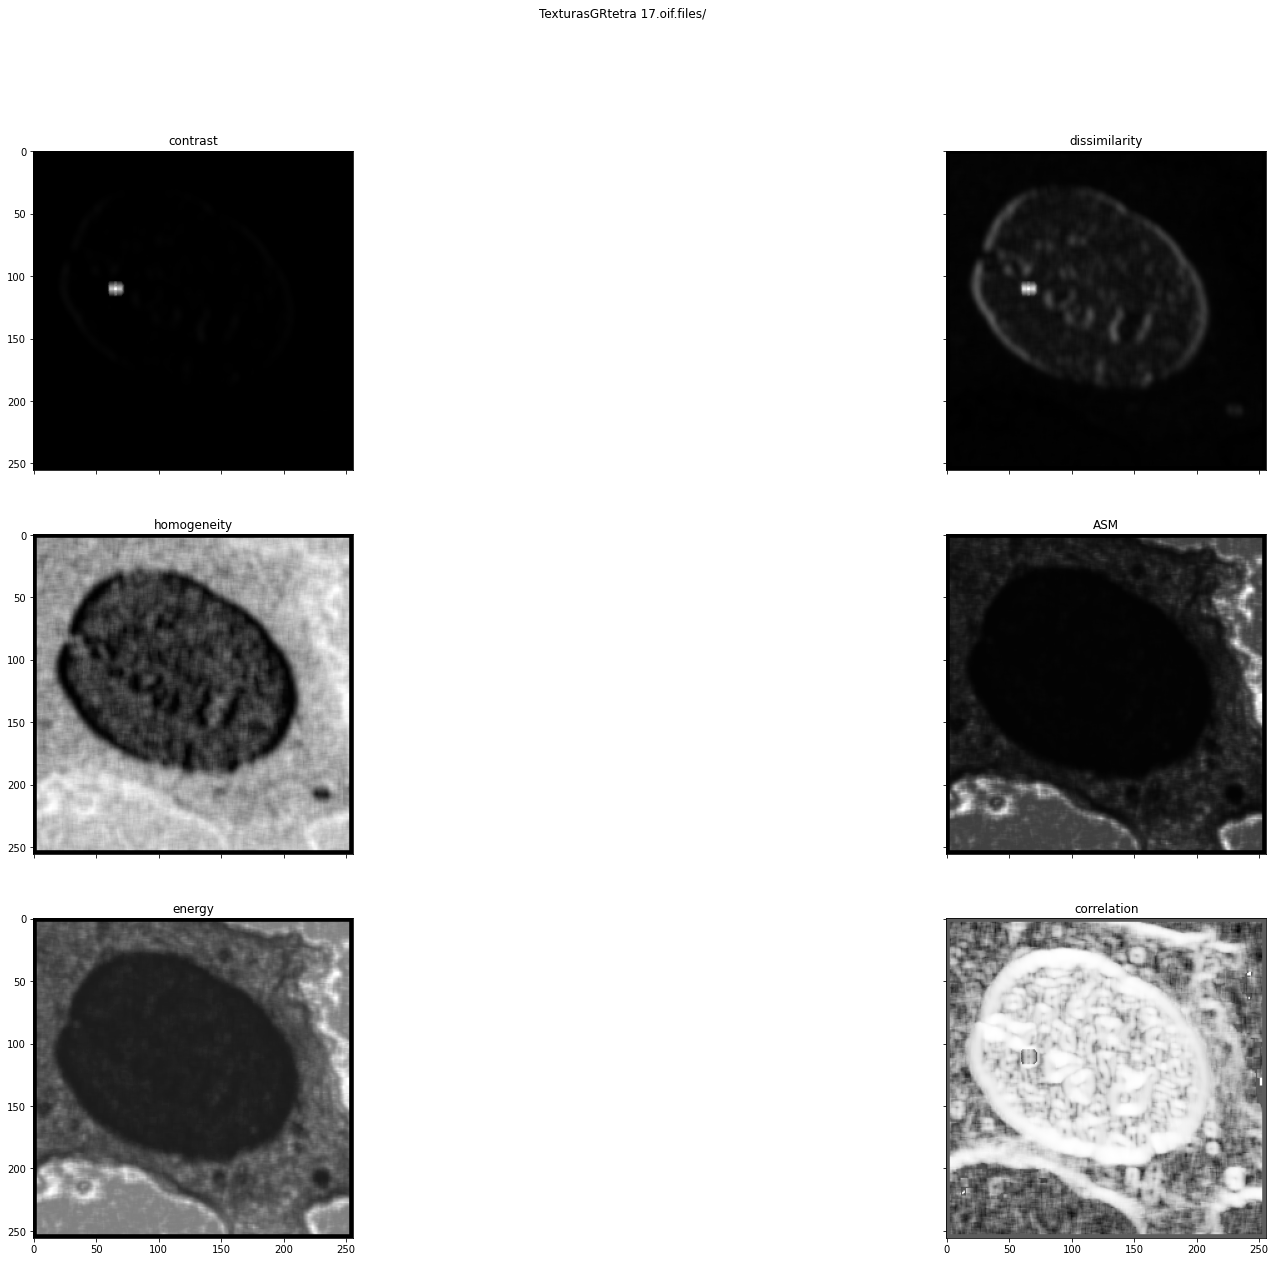

<Figure size 432x288 with 0 Axes>

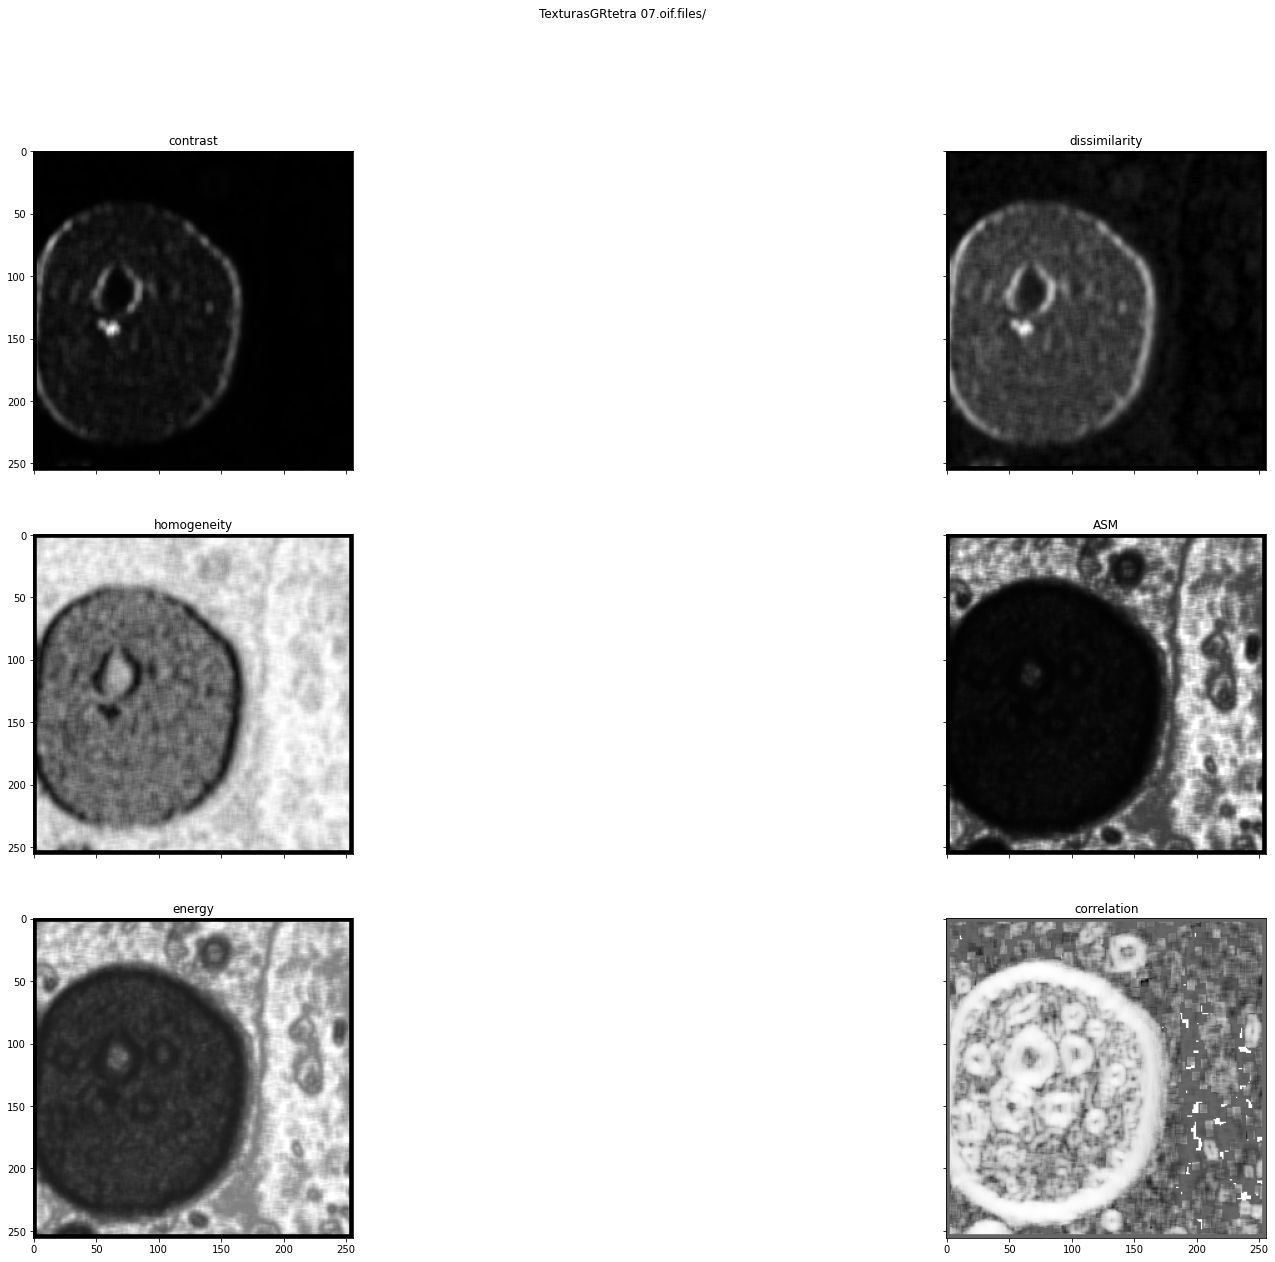

<Figure size 432x288 with 0 Axes>

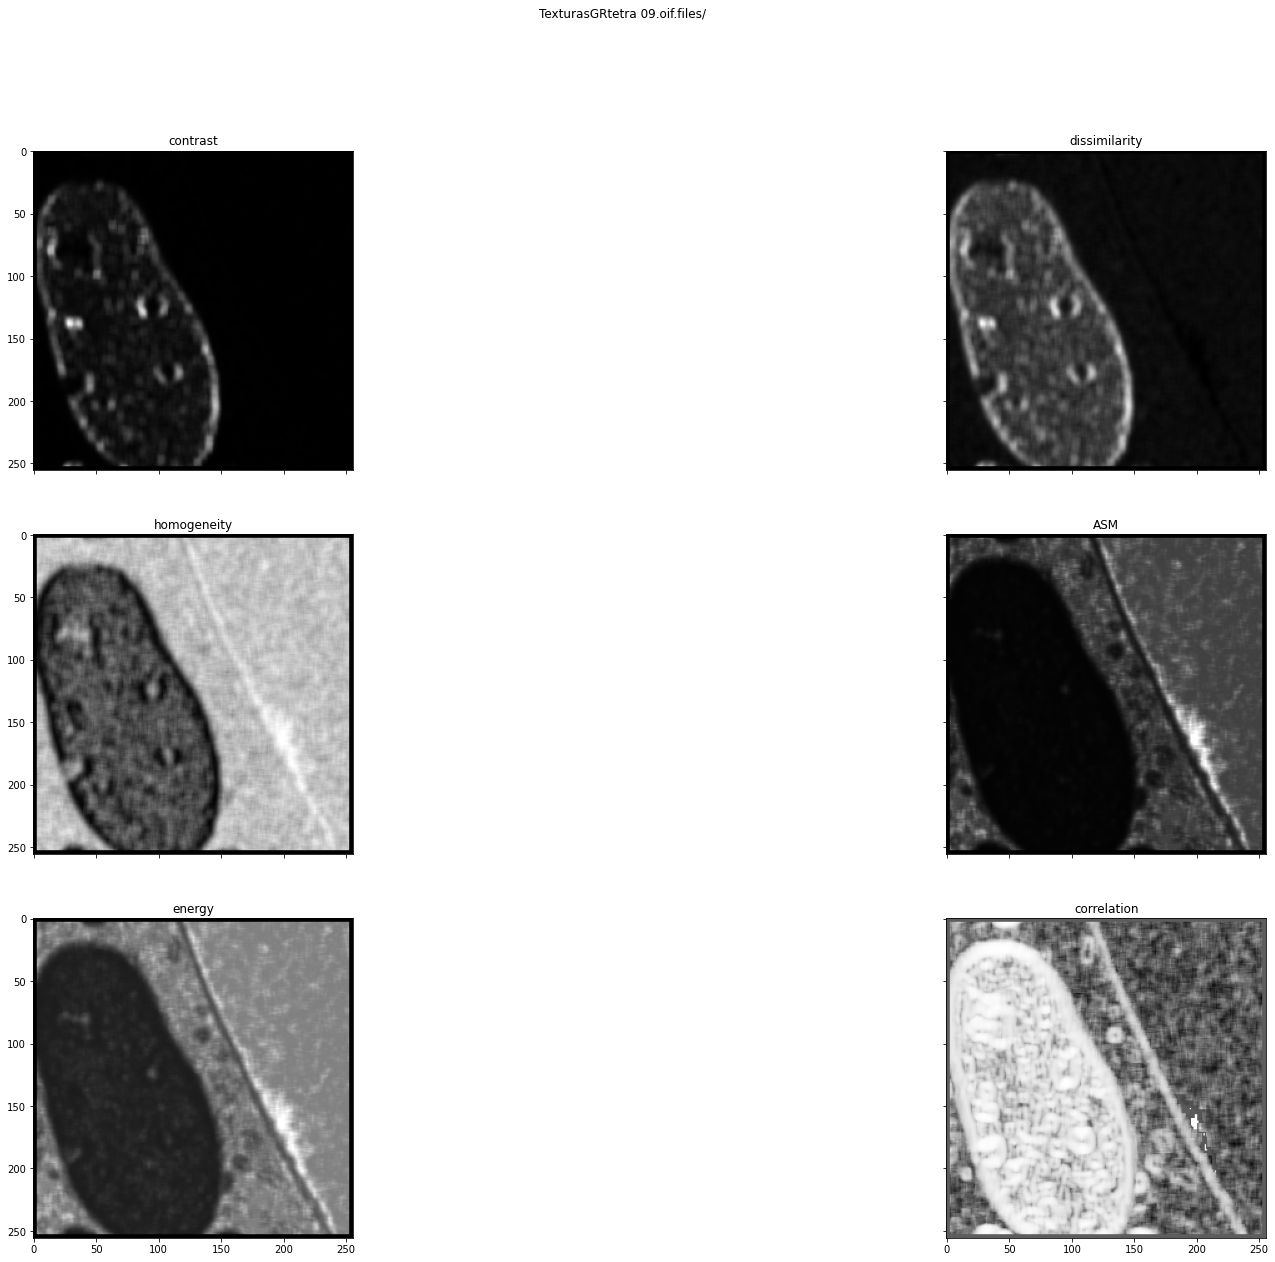

In [163]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GFPGRtetra/'
trat = 'GR'
for i in range(len(os.listdir(path))):
    cell = os.listdir(path)[i]
    cell = cell+'/'
    cellcode = cell[0:8]
    dfFinals[i] = CalcularAtributos(i%5==0,path, trat, cell, window, features, cellcode, dfByCell[i])

In [187]:
df_total = pd.concat(dfFinals.values(), ignore_index=True)

df_total.to_csv('Celulas_RF/df_final/'+path.split('/')[:-1][-1]+'_'+trat+'_atributos.csv')

In [188]:
df_total.tail()

,Unnamed: 0,Mean,Brightness,target,Celula_ID,contrast,dissimilarity,homogeneity,ASM,energy,correlation
917499,65531,0.002678,0.239080,BACKGROUND,16/,0.0,0.0,0.0,0.0,0.0,0.0
917500,65532,0.004285,0.209039,BACKGROUND,16/,0.0,0.0,0.0,0.0,0.0,0.0
917501,65533,0.002678,0.168983,BACKGROUND,16/,0.0,0.0,0.0,0.0,0.0,0.0
917502,65534,0.001607,0.171487,BACKGROUND,16/,0.0,0.0,0.0,0.0,0.0,0.0
917503,65535,0.002142,0.170235,BACKGROUND,16/,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
path = '/home/bruno/Documents/UBA/Reconocimiento de patrones/data TP-final/GPFGRY551C/'
trat = 'GR'
for i in range(len(os.listdir(path))):
    cell = os.listdir(path)[i]
    cell = cell+'/'
    cellcode = cell[0:8]
    dfFinals[i] = CalcularAtributos(i%5==0,path, trat, cell, window, features, cellcode, dfByCell[i])

In [ ]:
path = directory+'20200304 N&B GRtetra Y551C Y551A/GFPGRtetra/'
trat = ''
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:10]
    CalcularAtributos(path, trat, cell, window, features, cellcode)

In [ ]:
path = directory+'20120612 GFPGR overexpress/CORT/'
trat = 'GR_CORT_'
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:2]
    CalcularAtributos(path, trat, cell, window, features, cellcode)

No sabemos si vamos a usar el Control todavía porque están invertidas las intensidades

path = directory+'20120612 GFPGR overexpress/Control/'
trat = 'GR_Control_'
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:2]
    print(cellcode)
    #CalcularAtributos(path, trat, cell, window, features, cellcode)

In [ ]:
path = directory+'20200311 N&B Fluorescein GRwt/GR525/'
trat = ''
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:8]
    CalcularAtributos(path, trat, cell, window, features, cellcode)

In [ ]:
path = directory+'20200311 N&B Fluorescein GRwt/GRwt/Dex/'
trat = ''
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:11]
    CalcularAtributos(path, trat, cell, window, features, cellcode)

No sabemos si vamos a usar el Control todavía porque están invertidas las intensidades

path = directory+'20200311 N&B Fluorescein GRwt/GRwt/Veh/'
trat = ''
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:11]
    print(cellcode)
    #CalcularAtributos(path, trat, cell, window, features, cellcode)

In [ ]:
path = directory+'20200228 N&B GRwt LXRa/GFPGRN525/'
trat = 'GRN525_'
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:2]
    CalcularAtributos(path, trat, cell, window, features, cellcode)

In [ ]:
path = directory+'20200228 N&B GRwt LXRa/GFPGRwt-dex/'
trat = 'GRwt-dex_'
for cell in os.listdir(path):
    cell = cell+'/'
    cellcode = cell[0:2]
    CalcularAtributos(path, trat, cell, window, features, cellcode)

# Una vez generados el dataset total de cada celula los concatenamos